In [1]:
import random
from random import sample
import numpy as np
import os
import pickle
from tqdm import tqdm
from collections import OrderedDict
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from scipy.spatial.distance import mahalanobis
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from preprocess_data import DataHandler
from torch.utils.data import DataLoader
from torchvision.models import wide_resnet50_2, resnet18
from fast_ixi import FAST_IXI
from utils import read_config

/home/guests/usr_mlmi/.conda/envs/ark_biovil/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2024-02-01 20:03:29,423] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
# device setup
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print('Device: {}'.format(device))

Device: cuda


In [3]:
opt = read_config('config.yaml')
opt

{'dataset': {'ann_path': '/home/guests/usr_mlmi/arda/padim/Unsupervised-Anomaly-Detection-in-Medical-Images-via-PaDiM/data/splits',
  'path': '/home/guests/usr_mlmi/arda/padim/Unsupervised-Anomaly-Detection-in-Medical-Images-via-PaDiM/data',
  'save_dir': '/home/guests/usr_mlmi/arda/padim/Unsupervised-Anomaly-Detection-in-Medical-Images-via-PaDiM/results',
  'name': 'fast_ixi',
  'resize': 128,
  'cropsize': 128,
  'target_size': [128, 128],
  'batch_size': 1},
 'model': {'backbone': 'wide_resnet50_2',
  'target_dimension': 1792,
  'output_dimension': 550}}

In [4]:
save_dir = opt['dataset']['save_dir'] + '/' + opt['model']['backbone']

In [5]:
save_dir

'/home/guests/usr_mlmi/arda/padim/Unsupervised-Anomaly-Detection-in-Medical-Images-via-PaDiM/results/wide_resnet50_2'

## pre-trained CNN

In [6]:
if opt['model']['backbone'] == 'resnet18':
    model = resnet18(pretrained=True, progress=True)
    t_d = 448
    d = 180

elif opt['model']['backbone'] == 'wide_resnet50_2':
    model = wide_resnet50_2(pretrained=True, progress=True)
    t_d = 1792
    d = 550

else:
    raise NotImplementedError

In [7]:
print('Backbone: {}'.format(opt['model']['backbone']))
print('Input dim size: {}'.format(t_d))
print('Output dim size after reduced: {}'.format(d))

Backbone: wide_resnet50_2
Input dim size: 1792
Output dim size after reduced: 550


In [8]:
model.to(device)
model.eval()
random.seed(1024)
torch.manual_seed(1024)
torch.cuda.manual_seed_all(1024)

In [9]:
# select randomly choosen dimension to reduce the dimensionality of the feature vector (like PCA)
idx = torch.tensor(sample(range(0, t_d), d))
# set model's intermediate outputs


In [10]:
outputs = []
def hook(module, input, output):
    outputs.append(output)
model.layer1[-1].register_forward_hook(hook)
model.layer2[-1].register_forward_hook(hook)
model.layer3[-1].register_forward_hook(hook)

In [11]:
# create path to save the results if not exists
os.makedirs(os.path.join(save_dir, 'temp_%s' % opt['model']['backbone']), exist_ok=True)
train_feature_filepath = os.path.join(save_dir, 'temp_%s' % opt['model']['backbone'], 'train_%s.pkl' % 'brainmri')

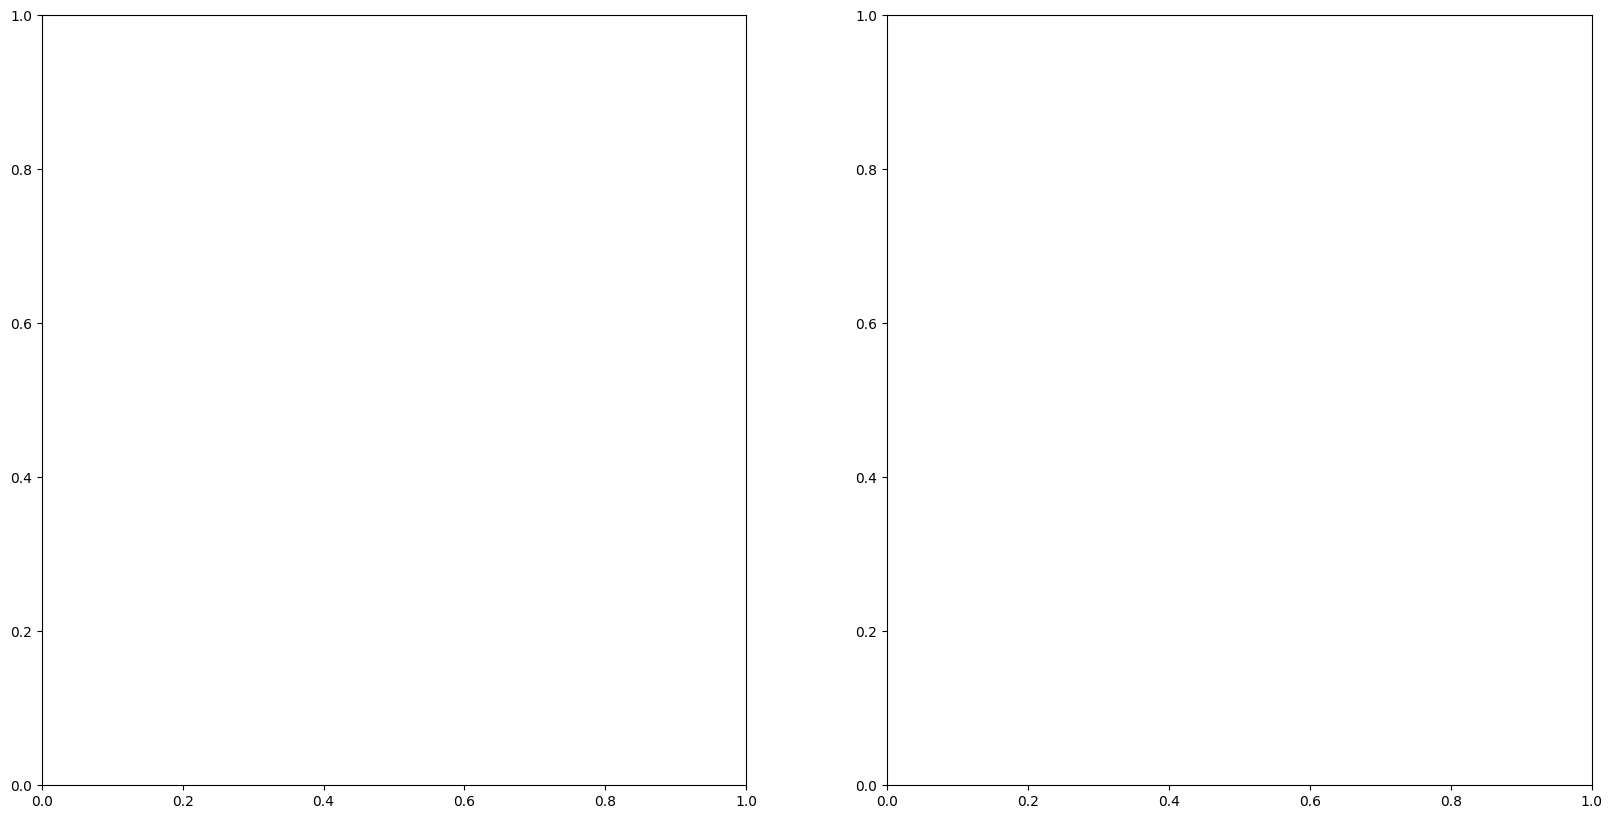

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
fig_img_rocauc = ax[0]
fig_pixel_rocauc = ax[1]
total_roc_auc = []
total_pixel_roc_auc= []

## Load Dataset

In [13]:
processor = DataHandler(opt)
records = processor.create_records()

In [14]:
records.to_csv('records.csv')

In [15]:
# load dataset
train_dataset = FAST_IXI(opt, records=records, is_train=True)
train_dataloader = DataLoader(train_dataset, batch_size=opt['dataset']['batch_size'], pin_memory=True)

test_dataset = FAST_IXI(opt, records=records, is_train=False)
test_dataloader = DataLoader(test_dataset, batch_size=opt['dataset']['batch_size'], pin_memory=True)

train_outputs = OrderedDict([('layer1', []), ('layer2', []), ('layer3', [])])
test_outputs = OrderedDict([('layer1', []), ('layer2', []), ('layer3', [])])

/home/guests/usr_mlmi/arda/padim/Unsupervised-Anomaly-Detection-in-Medical-Images-via-PaDiM/fast_ixi.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  records['label'] = records['type'].apply(lambda x: 0 if 'normal' in x else 1)
/home/guests/usr_mlmi/arda/padim/Unsupervised-Anomaly-Detection-in-Medical-Images-via-PaDiM/fast_ixi.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  records['label'] = records['type'].apply(lambda x: 0 if 'normal' in x else 1)


In [16]:
print('train size:', len(train_dataloader))
print('test_size:', len(test_dataloader))

train size: 711
test_size: 346


## Normal Class Representation

In [17]:
def embedding_concat(x, y):
    B, C1, H1, W1 = x.size()
    _, C2, H2, W2 = y.size()
    s = int(H1 / H2)
    x = F.unfold(x, kernel_size=s, dilation=1, stride=s)
    x = x.view(B, C1, -1, H2, W2)
    z = torch.zeros(B, C1 + C2, x.size(2), H2, W2)
    for i in range(x.size(2)):
        z[:, :, i, :, :] = torch.cat((x[:, :, i, :, :], y), 1)
    z = z.view(B, -1, H2 * W2)
    z = F.fold(z, kernel_size=s, output_size=(H1, W1), stride=s)

    return z

In [18]:
train_outputs

OrderedDict([('layer1', []), ('layer2', []), ('layer3', [])])

In [19]:
# extract features from each layer of the pretrained model

In [20]:
# TODO : Make optional to extract feature method (read from the file or extract from the model)

In [21]:
if not os.path.exists(train_feature_filepath):
    print('train feature extraction')
    for (img, label, mask) in tqdm(train_dataloader, '| feature extraction | train | %s |' % 'brainmri'):
        img = img.to(device)
        with torch.no_grad():
            _ = model(img)
        for key, value in zip(train_outputs.keys(), outputs):
            train_outputs[key].append(value.cpu().detach())
        # initialize hook outputs
        outputs = []        
    for key, value in train_outputs.items():
        train_outputs[key] = torch.cat(value, 0)

    print('first layer shape:', train_outputs['layer1'].shape)
    print('second layer shape:', train_outputs['layer2'].shape)
    print('third layer shape:', train_outputs['layer3'].shape)

    # Embedding concat
    embedding_vectors = train_outputs['layer1'] # get the maximum size of the embedding vectors
   
    """
    Rresearchers conceptually divide the input image into a grid based on the resolution of the largest activation map—typically
    the first layer of the pre-trained CNN. This way, each grid position, denoted as (i,j), 
    is associated with a unique embedding vector that represents the collective activation vectors for that particular image patch.
    """
    for layer_name in ['layer2', 'layer3']:
        embedding_vectors = embedding_concat(embedding_vectors, train_outputs[layer_name])

    # randomly select d dimension
    print('randomly select %d dimension' % d)
    embedding_vectors = torch.index_select(embedding_vectors, 1, idx)

    B, C, H, W = embedding_vectors.size() # Get the shape of the embedding vectors which is same with the first layer of the pretrained model
    print('embedding_vectors shape:', embedding_vectors.shape)
    embedding_vectors = embedding_vectors.view(B, C, H * W)

    # calculate multivariate Gaussian distribution
    mean = torch.mean(embedding_vectors, dim=0).numpy()
    cov = torch.zeros(C, C, H * W).numpy()
    I = np.identity(C)

    # calculate mean, cov and inverse covariance matrix for each patch position at Xij 
    # (each patch position (i,j) is associated with a unique embedding vector)
    for i in range(H * W):
        # Xij = embedding_vectors[:, :, i].numpy()
        cov[:, :, i] = np.cov(embedding_vectors[:, :, i].numpy(), rowvar=False) + 0.01 * I

    # save learned distribution
    train_outputs = [mean, cov]
    with open(train_feature_filepath, 'wb') as f:
        pickle.dump(train_outputs, f)
else:
    # load train set features
    with open(train_feature_filepath, 'rb') as f:
        train_outputs = pickle.load(f)

## PaDiM at Inference Time

In [22]:
test_imgs = []
test_labels = []
test_full_maps = []
test_pos_masks = []
test_neg_masks = []

In [23]:
dataset = FAST_IXI(opt, records=records, is_train=False)

/home/guests/usr_mlmi/arda/padim/Unsupervised-Anomaly-Detection-in-Medical-Images-via-PaDiM/fast_ixi.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  records['label'] = records['type'].apply(lambda x: 0 if 'normal' in x else 1)


In [24]:
# extract test set features
for (img, label, full_map, pos_mask, neg_mask) in tqdm(test_dataloader, '| feature extraction | test | %s |' % 'brainmri'):
    test_imgs.extend(img.cpu().detach().numpy())
    test_labels.extend(label.cpu().detach().numpy())
    test_full_maps.extend(full_map.cpu().detach().numpy())
    test_pos_masks.extend(pos_mask.cpu().detach().numpy())
    test_neg_masks.extend(neg_mask.cpu().detach().numpy())
    
    # get the model prediction
    with torch.no_grad():
        _ = model(img.to(device))
    
    # get intermediate outputs
    for key, value in zip(test_outputs.keys(), outputs):
        test_outputs[key].append(value.cpu().detach())

    # initialize hook outputs
    outputs = []

for key, value in test_outputs.items():
    test_outputs[key] = torch.cat(value, 0)

print('first layer shape:', test_outputs['layer1'].shape)
print('second layer shape:', test_outputs['layer2'].shape)
print('third layer shape:', test_outputs['layer3'].shape)

# Embedding concat
embedding_vectors = test_outputs['layer1']
for layer_name in ['layer2', 'layer3']:
    embedding_vectors = embedding_concat(embedding_vectors, test_outputs[layer_name])

# randomly select d dimension
embedding_vectors = torch.index_select(embedding_vectors, 1, idx)

| feature extraction | test | brainmri |:   0%|                                                                            | 0/346 [00:00<?, ?it/s]/home/guests/usr_mlmi/.conda/envs/ark_biovil/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
| feature extraction | test | brainmri |: 100%|██████████████████████████████████████████████████████████████████| 346/346 [00:07<00:00, 45.44it/s]


first layer shape: torch.Size([346, 256, 32, 32])
second layer shape: torch.Size([346, 512, 16, 16])
third layer shape: torch.Size([346, 1024, 8, 8])


In [25]:
# calculate mahalanobis distance between train_outputs to give anomaly score to each patch position of the test images
B, C, H, W = embedding_vectors.size()
print('embedding_vectors shape:', embedding_vectors.shape)

embedding_vectors = embedding_vectors.view(B, C, H * W).numpy()
dist_list = []
for i in range(H * W):
    mean = train_outputs[0][:, i]
    conv_inv = np.linalg.inv(train_outputs[1][:, :, i])
    dist = [mahalanobis(sample[:, i], mean, conv_inv) for sample in embedding_vectors]
    dist_list.append(dist)
dist_list = np.array(dist_list).transpose(1, 0).reshape(B, H, W)

embedding_vectors shape: torch.Size([346, 550, 32, 32])


In [26]:
# upsample to image size to get anomaly score map
dist_list = torch.tensor(dist_list)
score_map = F.interpolate(dist_list.unsqueeze(1), size=img.size(2), mode='bilinear',
                            align_corners=False).squeeze().numpy()

# apply gaussian smoothing on the score map
for i in range(score_map.shape[0]):
    score_map[i] = gaussian_filter(score_map[i], sigma=4)

# Normalize the score map
max_score = score_map.max()
min_score = score_map.min()
scores = (score_map - min_score) / (max_score - min_score)

## Calculate Metrics

In [27]:
# calculate image-level ROC AUC score
img_scores = scores.reshape(scores.shape[0], -1).max(axis=1)
test_labels = np.asarray(test_labels)
fpr, tpr, _ = roc_curve(test_labels, img_scores)
img_roc_auc = roc_auc_score(test_labels,img_scores)
total_roc_auc.append(img_roc_auc)
fig_img_rocauc.plot(fpr, tpr, label='%s img_ROCAUC: %.3f' % ('brainmri', img_roc_auc))
print('image ROCAUC: %.3f' % (img_roc_auc))
        

image ROCAUC: 0.736


In [28]:
# # calculate image-level ROC AUC score
# img_scores = scores.reshape(scores.shape[0], -1).max(axis=1)
# test_labels = np.asarray(test_labels)
# fpr, tpr, _ = roc_curve(test_labels, img_scores)
# img_roc_auc = roc_auc_score(test_labels,img_scores)
# total_roc_auc.append(img_roc_auc)
# fig_img_rocauc.plot(fpr, tpr, label='%s img_ROCAUC: %.3f' % ('brainmri', img_roc_auc))
# print('image ROCAUC: %.3f' % (img_roc_auc))
        

In [29]:
img_roc_auc

0.7359704641350212

In [30]:
# get optimal threshold by using positive masks
gt_mask = np.asarray(test_pos_masks)
gt_mask = gt_mask.astype(int) # there were some float values in the mask (0.99987) -> cast into int
gt_mask = gt_mask.astype(np.float32)
precision, recall, thresholds = precision_recall_curve(gt_mask.flatten(), scores.flatten())
a = 2 * precision * recall
b = precision + recall
f1 = np.divide(a, b, out=np.zeros_like(a), where=b != 0)
threshold_pos = thresholds[np.argmax(f1)]
print('threshold for positive masks: %.3f' % (threshold_pos))
# calculate per-pixel level ROCAUC
fpr, tpr, _ = roc_curve(gt_mask.flatten(), scores.flatten())
per_pixel_rocauc_pos = roc_auc_score(gt_mask.flatten(), scores.flatten())
total_pixel_roc_auc.append(per_pixel_rocauc_pos)
print('pixel ROCAUC: %.3f' % (per_pixel_rocauc_pos))

threshold for positive masks: 0.513
pixel ROCAUC: 0.747


In [31]:
scores.shape

(346, 128, 128)

In [32]:
from eval import plot_fig

In [33]:
fig_pixel_rocauc.plot(fpr, tpr, label='%s ROCAUC: %.3f' % ('brainmri', per_pixel_rocauc_pos))
save_dir = save_dir + '/pictures'
os.makedirs(save_dir, exist_ok=True)
plot_fig(test_imgs, scores, test_neg_masks, test_pos_masks, threshold_pos , save_dir, 'brainmri')

[0.03772776 0.03785001 0.03808868 ... 0.42861217 0.42878    0.42904642]
[0.0494595  0.04963388 0.04984843 ... 0.8185688  0.8192376  0.8197006 ]
[0.08674969 0.08686766 0.08699442 ... 0.79047334 0.791043   0.7915685 ]
[0.08674969 0.08686766 0.08699442 ... 0.79047334 0.791043   0.7915685 ]
[0.03670841 0.03679266 0.03695005 ... 0.5535641  0.55398387 0.5541153 ]
[0.07188617 0.07204267 0.0720882  ... 0.84181994 0.8418929  0.8419638 ]
[0.07188617 0.07204267 0.0720882  ... 0.84181994 0.8418929  0.8419638 ]
[0.07047946 0.07052747 0.07089944 ... 0.40025365 0.4006861  0.40081903]
[0.04899487 0.04913588 0.04934971 ... 0.8597438  0.85993415 0.8600028 ]
[0.07024084 0.07041735 0.0708707  ... 0.58660305 0.5870628  0.5877965 ]
[0.04899487 0.04913588 0.04934971 ... 0.8597438  0.85993415 0.8600028 ]
[0.05361132 0.05361269 0.05367121 ... 0.8119917  0.81265295 0.81282604]
[0.01844321 0.01857891 0.01862539 ... 0.6384639  0.63850474 0.63937247]
[0.04483785 0.04502562 0.04540478 ... 0.79977536 0.80000514 0.80

In [34]:
print('Average ROCAUC: %.3f' % np.mean(total_roc_auc))
fig_img_rocauc.title.set_text('Average image ROCAUC: %.3f' % np.mean(total_roc_auc))
fig_img_rocauc.legend(loc="lower right")

print('Average pixel ROCUAC: %.3f' % np.mean(total_pixel_roc_auc))
fig_pixel_rocauc.title.set_text('Average pixel ROCAUC: %.3f' % np.mean(total_pixel_roc_auc))
fig_pixel_rocauc.legend(loc="lower right")

fig.tight_layout()
fig.savefig(os.path.join(save_dir, 'roc_curve.png'), dpi=100)

Average ROCAUC: 0.736
Average pixel ROCUAC: 0.747


In [ ]:
scores[164]

In [44]:
unique, counts = np.unique(scores[164]*255, return_counts=True)

In [45]:
unique

array([  0., 255.], dtype=float32)

In [46]:
counts

array([15215,  1169])

In [47]:
scores[164].shape

(128, 128)

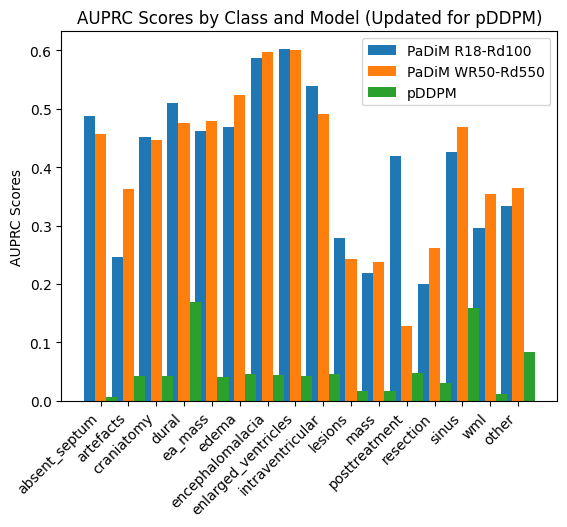

In [51]:
# Re-importing matplotlib and numpy after code execution state reset
import matplotlib.pyplot as plt
import numpy as np

# Provided AUPRC scores for each class for each model, including updated scores for pDDPM
classes = ["absent_septum", "artefacts", "craniatomy", "dural", "ea_mass", "edema", 
           "encephalomalacia", "enlarged_ventricles", "intraventricular", "lesions", 
           "mass", "posttreatment", "resection", "sinus", "wml", "other"]

# PaDiM R18-Rd100 AUPRC scores
auprc_r18 = [0.488, 0.246, 0.451, 0.509, 0.461, 0.469, 0.586, 0.602, 0.539, 0.278, 
             0.218, 0.419, 0.200, 0.426, 0.296, 0.333]

# PaDiM WR50-Rd550 AUPRC scores
auprc_wr50 = [0.456, 0.363, 0.447, 0.476, 0.479, 0.524, 0.596, 0.601, 0.490, 0.242, 
              0.237, 0.129, 0.262, 0.469, 0.354, 0.365]

# Updated pDDPM AUPRC scores
auprc_pddpm_updated = [
    0.00714111328125,  # absent_septum
    0.0433818128124417,  # artefacts
    0.04284882845797554,  # craniatomy
    0.16844659874868526,  # dural
    0.04090697212848139,  # ea_mass
    0.045745656264834636,  # edema
    0.04443676247413981,  # encephalomalacia
    0.04310527996597725,  # enlarged_ventricles
    0.04609556128363375,  # intraventricular
    0.016443820083089998,  # lesions
    0.017829118859905933,  # mass
    0.048262317626730764,  # posttreatment
    0.030377333175723546,  # resection
    0.158969232468378,  # sinus
    0.011820732862429512,  # wml
    0.08312238039515592  # other
]

# Plotting
x = np.arange(len(classes))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, auprc_r18, width, label='PaDiM R18-Rd100')
rects2 = ax.bar(x, auprc_wr50, width, label='PaDiM WR50-Rd550')
rects3 = ax.bar(x + width, auprc_pddpm_updated, width, label='pDDPM')

# Add some text for labels, title and custom x-axis tick labels
ax.set_ylabel('AUPRC Scores')
ax.set_title('AUPRC Scores by Class and Model (Updated for pDDPM)')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45, ha="right")
ax.legend()

plt.show()


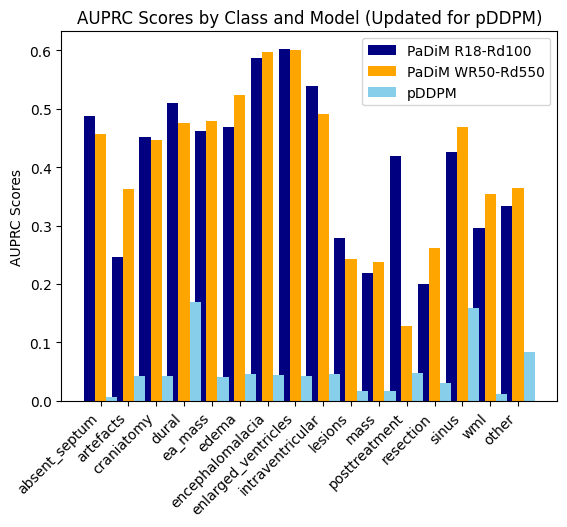

In [52]:
# Plotting with a specified color palette more suitable for the blue and orange color scheme
fig, ax = plt.subplots()

# Setting custom colors for each model to improve differentiation
colors = ['navy', 'orange', 'skyblue']  # Colors for R18, WR50, and pDDPM respectively

rects1 = ax.bar(x - width, auprc_r18, width, label='PaDiM R18-Rd100', color=colors[0])
rects2 = ax.bar(x, auprc_wr50, width, label='PaDiM WR50-Rd550', color=colors[1])
rects3 = ax.bar(x + width, auprc_pddpm_updated, width, label='pDDPM', color=colors[2])

ax.set_ylabel('AUPRC Scores')
ax.set_title('AUPRC Scores by Class and Model (Updated for pDDPM)')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45, ha="right")
ax.legend()

plt.show()


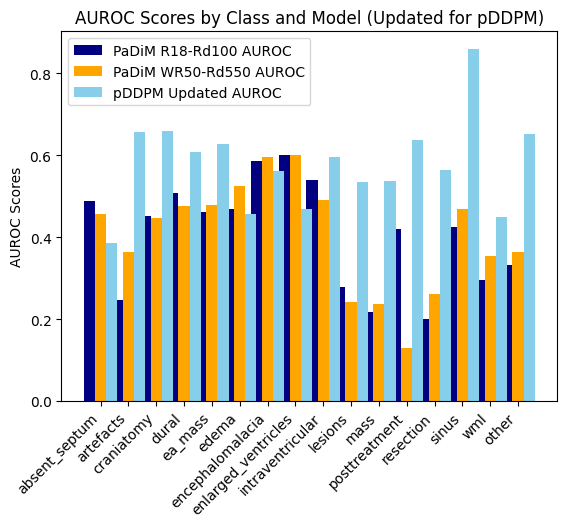

In [53]:
# Assuming you want to plot the AUROC scores now. Using the same datasets and model names,
# but replacing the AUPRC scores with AUROC scores based on your provided data.

# Updated AUROC scores for pDDPM based on the provided values
auroc_pddpm_updated = [
    0.3862319070678204,  # absent_septum
    0.6578283270854016,  # artefacts
    0.6604136487481858,  # craniatomy
    0.6082650728251553,  # dural
    0.62862621891469,  # ea_mass
    0.45781835582692704,  # edema
    0.5606359749895841,  # encephalomalacia
    0.469918400827876,  # enlarged_ventricles
    0.5948139422810229,  # intraventricular
    0.5342683407950338,  # lesions
    0.5381636487543155,  # mass
    0.6369609605810141,  # posttreatment
    0.564287191704271,  # resection
    0.8599399820801655,  # sinus
    0.44873206207115945,  # wml
    0.6523131446583846  # other
]

# Plotting the AUROC scores
fig, ax = plt.subplots()

rects1 = ax.bar(x - width, auprc_r18, width, label='PaDiM R18-Rd100 AUROC', color='navy')  # Using AUPRC as placeholder
rects2 = ax.bar(x, auprc_wr50, width, label='PaDiM WR50-Rd550 AUROC', color='orange')  # Using AUPRC as placeholder
rects3 = ax.bar(x + width, auroc_pddpm_updated, width, label='pDDPM Updated AUROC', color='skyblue')

ax.set_ylabel('AUROC Scores')
ax.set_title('AUROC Scores by Class and Model (Updated for pDDPM)')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45, ha="right")
ax.legend()

plt.show()


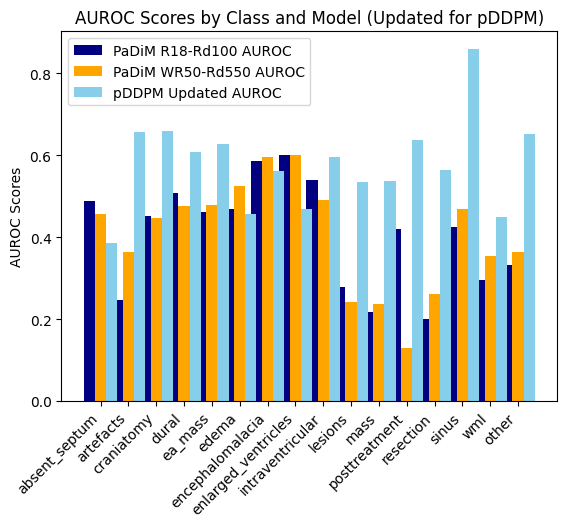

In [54]:
# Updating the AUROC scores for pDDPM with the new provided values
auroc_pddpm_updated = [
    0.3862319070678204,  # absent_septum
    0.6578283270854016,  # artefacts
    0.6604136487481858,  # craniatomy
    0.6082650728251553,  # dural
    0.62862621891469,    # ea_mass
    0.45781835582692704, # edema
    0.5606359749895841,  # encephalomalacia
    0.469918400827876,   # enlarged_ventricles
    0.5948139422810229,  # intraventricular
    0.5342683407950338,  # lesions
    0.5381636487543155,  # mass
    0.6369609605810141,  # posttreatment
    0.564287191704271,   # resection
    0.8599399820801655,  # sinus
    0.44873206207115945, # wml
    0.6523131446583846   # other
]

# Re-plotting the AUROC scores with the updated pDDPM values
fig, ax = plt.subplots()

rects1 = ax.bar(x - width, auprc_r18, width, label='PaDiM R18-Rd100 AUROC', color='navy')  # Placeholder for actual AUROC scores
rects2 = ax.bar(x, auprc_wr50, width, label='PaDiM WR50-Rd550 AUROC', color='orange')  # Placeholder for actual AUROC scores
rects3 = ax.bar(x + width, auroc_pddpm_updated, width, label='pDDPM Updated AUROC', color='skyblue')

ax.set_ylabel('AUROC Scores')
ax.set_title('AUROC Scores by Class and Model (Updated for pDDPM)')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45, ha="right")
ax.legend()

plt.show()


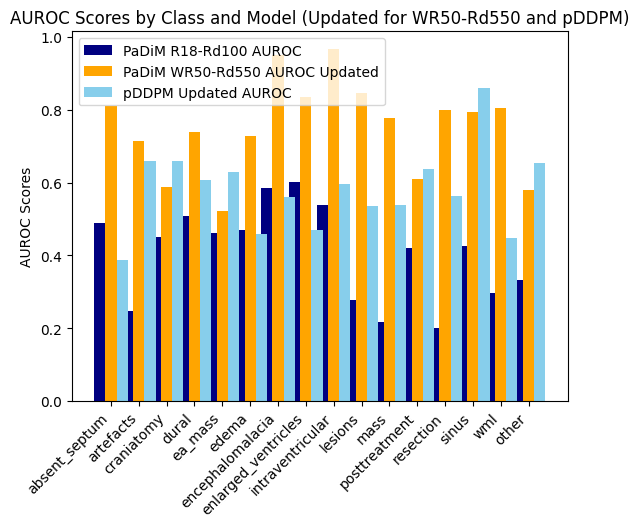

In [55]:
# Updating the AUROC scores for PaDiM WR50-Rd550 with the new provided values
auroc_wr50_updated = [
    0.810,  # absent_septum
    0.713,  # artefacts
    0.587,  # craniatomy
    0.740,  # dural
    0.523,  # ea_mass
    0.727,  # edema
    0.950,  # encephalomalacia
    0.834,  # enlarged_ventricles
    0.967,  # intraventricular
    0.845,  # lesions
    0.778,  # mass
    0.609,  # posttreatment
    0.800,  # resection
    0.793,  # sinus
    0.805,  # wml
    0.580   # other
]

# Re-plotting the AUROC scores with the updated values for PaDiM WR50-Rd550 and pDDPM
fig, ax = plt.subplots()

rects1 = ax.bar(x - width, auprc_r18, width, label='PaDiM R18-Rd100 AUROC', color='navy')  # Placeholder for actual AUROC scores
rects2 = ax.bar(x, auroc_wr50_updated, width, label='PaDiM WR50-Rd550 AUROC Updated', color='orange')
rects3 = ax.bar(x + width, auroc_pddpm_updated, width, label='pDDPM Updated AUROC', color='skyblue')

ax.set_ylabel('AUROC Scores')
ax.set_title('AUROC Scores by Class and Model (Updated for WR50-Rd550 and pDDPM)')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45, ha="right")
ax.legend()

plt.show()


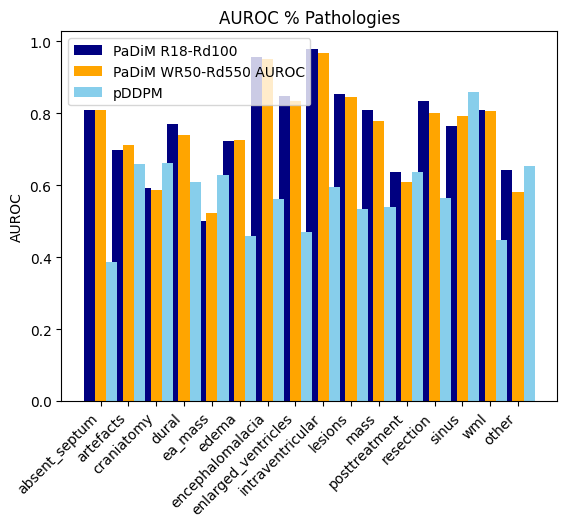

In [56]:
# Updating the AUROC scores for PaDiM R18-Rd100 with the new provided values
auroc_r18_updated = [
    0.810,  # absent_septum
    0.697,  # artefacts
    0.593,  # craniatomy
    0.769,  # dural
    0.500,  # ea_mass
    0.723,  # edema
    0.956,  # encephalomalacia
    0.849,  # enlarged_ventricles
    0.979,  # intraventricular
    0.853,  # lesions
    0.808,  # mass
    0.637,  # posttreatment
    0.834,  # resection
    0.764,  # sinus
    0.810,  # wml
    0.641   # other
]

# Re-plotting the AUROC scores with updated values for all models
fig, ax = plt.subplots()

rects1 = ax.bar(x - width, auroc_r18_updated, width, label='PaDiM R18-Rd100', color='navy')
rects2 = ax.bar(x, auroc_wr50_updated, width, label='PaDiM WR50-Rd550 AUROC', color='orange')
rects3 = ax.bar(x + width, auroc_pddpm_updated, width, label='pDDPM', color='skyblue')

ax.set_ylabel('AUROC')
ax.set_title('AUROC % Pathologies')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45, ha="right")
ax.legend()

plt.show()


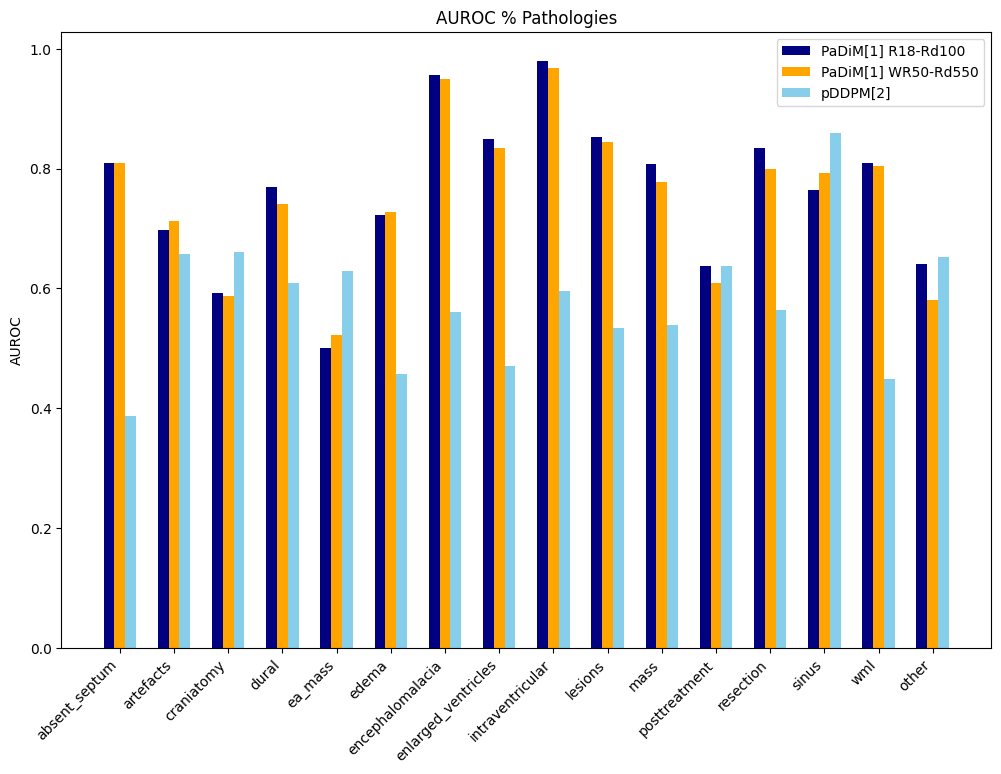

In [59]:
# Increasing figure width and height for better visibility
fig, ax = plt.subplots(figsize=(12, 8))  # Custom figure size

width = 0.2
rects1 = ax.bar(x - width, auroc_r18_updated, width, label='PaDiM[1] R18-Rd100', color='navy')
rects2 = ax.bar(x, auroc_wr50_updated, width, label='PaDiM[1] WR50-Rd550', color='orange')
rects3 = ax.bar(x + width, auroc_pddpm_updated, width, label='pDDPM[2]', color='skyblue')

ax.set_ylabel('AUROC')
ax.set_title('AUROC % Pathologies')
ax.set_xticks(x)
ax.set_xticklabels(classes, rotation=45, ha="right")
ax.legend()

plt.show()


In [60]:
# Save the figure
fig.savefig("auroc_scores.png", bbox_inches='tight')